In [1]:
import pandas as pd
import sqlite3

In [2]:
path = "Data/im.db"
conn = sqlite3.connect(path)
cur = conn.cursor()


In [3]:
pd.read_sql("""SELECT name
            FROM sqlite_master
            WHERE type = 'table';
""",conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [4]:
bom = pd.read_csv("Data/bom.movie_gross.csv")
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [6]:
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')


In [7]:
print(bom['domestic_gross'].isna().sum())
print(bom['foreign_gross'].isna().sum())

28
1355


In [8]:
x= bom[bom['domestic_gross'].isna() & bom['foreign_gross'].isna()]
x

,title,studio,domestic_gross,foreign_gross,year


In [9]:
# Fill null values with 0
bom['domestic_gross'].fillna(0, inplace=True)
bom['foreign_gross'].fillna(0, inplace=True)

In [10]:
bom['studio'].unique()
bom['studio'].isna().sum()


5

In [11]:
bom['studio'].value_counts().head()

IFC      166
Uni.     147
WB       140
Fox      136
Magn.    136
Name: studio, dtype: int64

In [12]:
#Fill null values with unknown
bom['studio'].fillna('Unknown', inplace=True)

In [13]:
# Movie Basics Table
pd.read_sql("""SELECT COUNT(*)
                FROM movie_basics
                WHERE genres IS NULL;
""", conn)

,COUNT(*)
0,0


In [14]:
pd.read_sql("""SELECT COUNT(*)
                FROM movie_basics
                WHERE runtime_minutes IS NULL;
""", conn)

,COUNT(*)
0,0


In [15]:
# Fill null values with 90 since average is usually 90 minutes

cur.execute("""
    UPDATE movie_basics
    SET runtime_minutes = 90
    WHERE runtime_minutes IS NULL;
""")
conn.commit()


In [16]:
cur.execute("""
                UPDATE movie_basics
                SET genres = 'Unknown'
                WHERE genres IS NULL;
""")
conn.commit()

In [17]:
# Separate those with multiple genres using | do that they can be counted individually
cur.execute("""
                UPDATE movie_basics
                SET genres = REPLACE(genres, ',', '|');
""")
conn.commit()

In [18]:
pd.read_sql("""SELECT genres, COUNT(*) AS genre_count
                FROM movie_basics
                GROUP BY genres
                ORDER BY genre_count DESC;
""", conn)

,genres,genre_count
0,Documentary,32185
1,Drama,21486
2,Comedy,9177
3,Unknown,5408
4,Horror,4372
...,...,...
1081,Action|Animation|Music,1
1082,Action|Animation|History,1
1083,Action|Animation|Documentary,1
1084,Action|Animation|Biography,1


In [19]:
# To count all movies with the genre Documentary
pd.read_sql("""SELECT COUNT(*) as documentaries
                FROM movie_basics
                WHERE genres LIKE '%Documentary%';
""", conn)

,documentaries
0,51640


In [20]:
pd.read_sql("""SELECT COUNT(*)
                FROM movie_ratings
                WHERE movie_id IS NULL
                OR averagerating IS NULL
                OR numvotes IS NULL;
""", conn)

,COUNT(*)
0,0


In [21]:
pd.read_sql("""SELECT COUNT(*)
                FROM movie_akas
                WHERE movie_id IS NULL
                OR ordering IS NULL
                OR title IS NULL;
""", conn)

,COUNT(*)
0,0


In [22]:
pd.read_sql("""SELECT COUNT(*)
                FROM directors
                WHERE movie_id IS NULL
                OR person_id IS NULL;
""", conn)

,COUNT(*)
0,0


In [23]:
tmdb = pd.read_csv("Data/tmdb.movies.csv")
tmdb.head()
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [24]:
## SQL table relations
#Length of movies
pd.read_sql("""SELECT *
                FROM movie_basics
                ORDER BY runtime_minutes DESC
                LIMIT 10;
""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt8273150,Logistics,Logistics,2012,51420.0,Documentary
1,tt2659636,Modern Times Forever,Modern Times Forever,2011,14400.0,Documentary
2,tt7492094,Nari,Nari,2017,6017.0,Documentary
3,tt5068890,Hunger!,Hunger!,2015,6000.0,Documentary|Drama
4,tt5136218,London EC1,London EC1,2015,5460.0,Comedy|Drama|Mystery
5,tt5240738,Ember Glow,Ember Glow,2015,4980.0,Drama|Western
6,tt1735956,Deregulation,Foreclose,2012,4200.0,Comedy|Drama
7,tt6150204,Nieuwe Tieten,Nieuwe Tieten,2013,4080.0,Documentary|Drama
8,tt1674154,City of Eternal Spring,City of Eternal Spring,2010,3450.0,Documentary|Drama|News
9,tt3837350,A 2nd generation film,A 2nd generation film,2013,3077.0,Drama


In [25]:
# Average ratings by genre
pd.read_sql("""SELECT
            genres, AVG(averagerating) AS avg_rating, SUM(numvotes) AS total_votes, COUNT(original_title) AS num_movies
                FROM movie_basics
                JOIN movie_ratings 
            ON movie_basics.movie_id= movie_ratings.movie_id
            GROUP BY genres
            ORDER BY avg_rating DESC
            LIMIT 10;
""", conn)

,genres,avg_rating,total_votes,num_movies
0,Comedy|Documentary|Fantasy,9.4,5,1
1,Documentary|Family|Musical,9.3,19,1
2,History|Sport,9.2,5,1
3,Music|Mystery,9.0,5,1
4,Game-Show,9.0,7,1
5,Drama|Short,8.8,8,1
6,Drama|Fantasy|War,8.8,22,1
7,Documentary|News|Sport,8.8,25,1
8,Documentary|News|Reality-TV,8.8,8,1
9,Comedy|Drama|Reality-TV,8.8,15,1


In [26]:
# # Read from database
# df = pd.read_sql("""
#     SELECT original_title, genres, averagerating
#     FROM movie_basics
#     JOIN movie_ratings USING (movie_id)
# """, conn)

# # Split on '/' and expand rows
# df = df.assign(genre=df['genres'].str.split('/')).explode('genre')

# # Now group by the individual genre
# result = (
#     df.groupby('genre', as_index=False)
#       .agg(avg_rating=('averagerating', 'mean'),
#            num_movies=('original_title', 'count'))
#       .sort_values('avg_rating', ascending=False)
# )
# print(result)


In [27]:
pd.read_sql("""SELECT
            genres, ROUND(AVG(averagerating),2) AS avg_rating, SUM(numvotes) AS total_votes, COUNT(original_title) AS num_movies
            FROM movie_basics
            JOIN movie_ratings 
                ON movie_basics.movie_id= movie_ratings.movie_id
            WHERE numvotes > 1000
            GROUP BY genres
            HAVING COUNT(original_title) > 2
            ORDER BY avg_rating DESC
            LIMIT 10;
""", conn)

,genres,avg_rating,total_votes,num_movies
0,Musical,8.18,8620,5
1,Documentary|History|Sport,8.03,5668,3
2,Documentary|Family,8.00,7987,3
3,Documentary|News,7.93,39758,6
4,Adventure|Biography|Documentary,7.93,19737,6
5,Documentary|History|War,7.90,29488,5
6,Documentary|Drama|News,7.87,8928,3
7,Comedy|Documentary|History,7.83,4384,3
8,Documentary|Sport,7.71,86138,25
9,Animation|Drama|Fantasy,7.68,226695,8


In [28]:
# Number of votes
pd.read_sql("""SELECT
            genres, ROUND(AVG(averagerating),2) AS avg_rating, SUM(numvotes) AS total_votes, COUNT(original_title) AS num_movies
            FROM movie_basics
            JOIN movie_ratings 
                ON movie_basics.movie_id= movie_ratings.movie_id
            WHERE numvotes > 1000
            GROUP BY genres
            HAVING COUNT(original_title) > 2
            ORDER BY total_votes DESC
            LIMIT 10;
""", conn)

,genres,avg_rating,total_votes,num_movies
0,Action|Adventure|Sci-Fi,6.18,23015643,77
1,Action|Adventure|Fantasy,5.69,9649573,64
2,Adventure|Animation|Comedy,6.36,8656839,122
3,Comedy|Drama|Romance,6.35,7514961,331
4,Action|Adventure|Comedy,5.63,7225420,90
5,Drama,6.76,7165635,752
6,Comedy,5.66,6120493,549
7,Comedy|Drama,6.54,6092942,471
8,Action|Crime|Drama,6.28,5503533,191
9,Drama|Romance,6.57,5338598,326


In [29]:
# Popularity Index(combines votes and rate into weighted popularity score)
# popularity score = average rating * numvotes / (numvotes + k) -> standardizing vote counts
pd.read_sql("""SELECT
                genres, AVG(averagerating * (numvotes *1.0/(numvotes+1000))) AS popularity_score, SUM(numvotes) AS total_votes
            FROM movie_basics
            JOIN movie_ratings 
                ON movie_basics.movie_id= movie_ratings.movie_id
            GROUP BY genres
            ORDER BY popularity_score DESC
            ;
""", conn)

,genres,popularity_score,total_votes
0,Documentary|Sport|Thriller,7.636482,28979
1,Drama|War|Western,6.149059,5851
2,Biography|Music|Romance,5.858862,3570
3,Comedy|Music|Thriller,5.852482,5587
4,Biography|Family|Sport,5.577648,3438
...,...,...,...
919,Family|War,0.028856,5
920,Horror|Musical|Romance,0.025871,5
921,Action|Crime|Musical,0.021891,5
922,Adventure|Crime|Romance,0.020515,9


In [1]:
tn = pd.read_csv("Data/tn,movie_budgets.csv")
tn.head()

NameError: name 'pd' is not defined

In [30]:
#gruoped years by average rating
pd.read_sql("""SELECT
            start_year, ROUND(AVG(averagerating),2) AS avg_rating, SUM(numvotes) AS total_votes
            FROM movie_basics
            JOIN movie_ratings 
                ON movie_basics.movie_id= movie_ratings.movie_id
            GROUP BY start_year
            ORDER BY avg_rating DESC;
""",conn)

,start_year,avg_rating,total_votes
0,2019,6.70,3070541
1,2018,6.42,16507889
2,2017,6.40,21901644
3,2016,6.35,26621703
4,2014,6.32,34382294
5,2012,6.30,32726315
6,2013,6.29,35638577
7,2011,6.29,32741501
8,2015,6.27,26167370
9,2010,6.26,30485759


In [31]:
#Grouping runtime and getting averages
pd.read_sql("""SELECT 
        CASE
           WHEN runtime_minutes < 90 THEN 'Short (<90)'
           WHEN runtime_minutes BETWEEN 90 AND 120 THEN 'Medium (90-120)'
           ELSE 'Long (>120)'
        END AS runtime_category,
        AVG(averagerating) AS avg_rating
        FROM movie_basics
        JOIN movie_ratings 
            USING (movie_id)
        GROUP BY runtime_category
        ORDER BY avg_rating DESC;
""", conn)

,runtime_category,avg_rating
0,Long (>120),6.477179
1,Short (<90),6.393324
2,Medium (90-120),6.264974


In [32]:
#Directors with the highest rating

pd.read_sql("""SELECT primary_name AS director,
                    AVG(averagerating) AS avg_rating,
                    COUNT(movie_id) AS movies_directed
                FROM directors 
                JOIN persons 
                    USING (person_id)
                JOIN movie_ratings 
                    USING (movie_id)
                GROUP BY primary_name
                HAVING movies_directed > 1
                ORDER BY avg_rating DESC
                LIMIT 10;
""", conn)

,director,avg_rating,movies_directed
0,Loreto Di Cesare,10.0,2
1,Ivana Diniz,10.0,2
2,Will Watson,9.7,2
3,Tyler Chandler,9.7,3
4,Steve Wystrach,9.7,2
5,Joe Heslinga,9.7,2
6,Vyacheslav Bihun,9.6,2
7,Taylor Morden,9.6,2
8,Julie Simone,9.6,3
9,Bart Hölscher,9.6,2


In [1]:
#Directors with the most movies
pd.read_sql("""SELECT primary_name AS director,
                    AVG(averagerating) AS avg_rating,
                    COUNT(movie_id) AS movies_directed
                FROM directors 
                JOIN persons 
                    USING (person_id)
                JOIN movie_ratings 
                    USING (movie_id)
                GROUP BY primary_name
                ORDER BY avg_rating DESC
                LIMIT 10;
""", conn)

NameError: name 'pd' is not defined

In [34]:
# pd.read_sql("""SELECT
#     original_title,
#     genres,
#     averagerating,
#     numvotes,
#     ((numvotes * averagerating + 1000 * 6.5) / (numvotes + 1000)) AS bayesian_score
# FROM movie_basics
# JOIN movie_ratings
#     USING (movie_id)
# ORDER BY bayesian_score DESC
# LIMIT 10;
# """, conn)

In [35]:
'''The results show, genres with the highest average rating and genres with the highest number of votes
    The results then grouped the runtimes with the hightest average rating
    The results grouped directors with average rating

'''

'The results show, genres with the highest average rating and genres with the highest number of votes\n    The results then grouped the runtimes with the hightest average rating\n    The results grouped directors with average rating\n\n'

In [36]:
# Grouped studios with the number of movies produced
top_studios = bom['studio'].value_counts()
print("The top 5 studios by count:")
print(top_studios.head())

The top 5 studios by count:
IFC      166
Uni.     147
WB       140
Magn.    136
Fox      136
Name: studio, dtype: int64


In [37]:
# Calculate the total gross and add column for total gross to millions for easy understanding
bom['total_gross'] = bom['domestic_gross'] + bom['foreign_gross']
bom['total_gross_millions'] =bom['domestic_gross']/1000000
bom.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,total_gross_millions
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09,415.0
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09,334.2
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08,296.0
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08,292.6
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08,238.7


In [ ]:
# Grouped studios with the mean total gross
studio_analysis = bom.groupby('studio')['total_gross_millions'].agg(
    ['mean', 'median', 'count']).sort_values(by='mean', ascending=False)
studio_analysis.head(10)

,mean,median,count
studio,,,
BV,173.764426,92.10,106
P/DW,168.290000,157.25,10
WB (NL),88.793333,63.10,45
Uni.,87.771381,61.00,147
WB,86.914614,47.25,140
Fox,80.511029,62.15,136
Sony,76.906210,62.00,110
Par.,76.097730,57.70,101
MGM,66.666667,50.30,3


In [39]:
# Grouped years with the mean total gross
average_gross_yr = bom.groupby('year')['total_gross_millions'].mean().sort_values(ascending=False)
average_gross_yr.head(10)

year
2018    36.010422
2017    34.060019
2010    30.966239
2013    30.835228
2012    27.191515
2014    26.171490
2016    25.811131
2011    25.223454
2015    24.558679
Name: total_gross_millions, dtype: float64

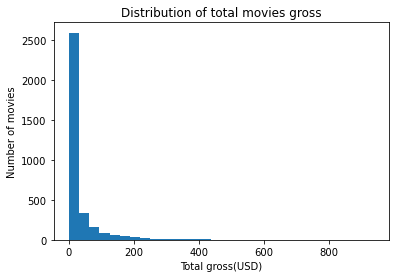

In [40]:
# Statistical distribution of the total gross
import matplotlib.pyplot as plt

plt.hist(bom['total_gross_millions'], bins=30)
plt.xlabel('Total gross(USD)')
plt.ylabel('Number of movies')
plt.title('Distribution of total movies gross')
plt.show()

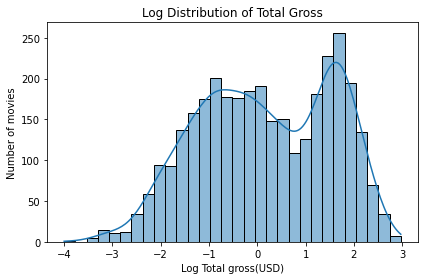

In [41]:
# Log transforming the total gross for normality since the graph was right skewed
import numpy as np
import seaborn as sns
sns.histplot(np.log10(bom[bom['total_gross_millions'] > 0]['total_gross_millions']), bins=30, kde=True)
plt.xlabel('Log Total gross(USD)')
plt.ylabel('Number of movies')
plt.title('Log Distribution of Total Gross')
plt.tight_layout()
plt.show()


In [42]:
bom['total_gross_millions'].describe()

count    3387.000000
mean       28.508206
std        66.755749
min         0.000000
25%         0.111500
50%         1.300000
75%        27.500000
max       936.700000
Name: total_gross_millions, dtype: float64

In [43]:
# Identify the two most prolific studios (by count) for a meaningful comparison
# top_2_studios = studio_analysis.sort_values('count', ascending=False).head(2).index.tolist()
# studio_a_name = top_2_studios[0] # The most prolific
# studio_b_name = top_2_studios[1] # The second most prolific
# print(top_2_studios)
# print(studio_a_name)
# print(studio_b_name)

In [44]:
# Identify top 2 performing studios financially
top_2_studios = studio_analysis.sort_values('mean', ascending=False).head(2).index.tolist()
studio_a_name = top_2_studios[0] # The best
studio_b_name = top_2_studios[1] # The second best performing
print(f'The best perfoming studio: {studio_a_name}')
print(f'The second best perfoming studio: {studio_b_name}')

# The total gross for the 2 studios
studio_a_gross = bom[bom['studio'] == studio_a_name]['total_gross']
studio_b_gross = bom[bom['studio'] == studio_b_name]['total_gross']

print(f'The mean total gross for studio_a: {studio_a_gross}')
print(f'The mean total gross for studio_b: {studio_b_gross}')


The best perfoming studio: BV
The second best perfoming studio: P/DW
The mean total gross for studio_a: 0       1.067000e+09
1       1.025500e+09
7       5.918000e+08
13      4.001000e+08
15      3.364000e+08
            ...     
3101    3.930000e+08
3107    3.496000e+08
3120    1.977000e+08
3122    1.740000e+08
3129    1.327000e+08
Name: total_gross, Length: 106, dtype: float64
The mean total gross for studio_b: 4      7.526000e+08
9      4.949000e+08
17     3.219000e+08
71     8.680000e+07
329    1.123800e+09
333    6.656000e+08
338    5.550000e+08
734    7.469000e+08
752    3.069000e+08
865    2.210000e+07
Name: total_gross, dtype: float64


In [ ]:
# Two sample independent t-test
from scipy import stats
test_statistic, p_value = stats.ttest_ind(studio_a_gross, studio_b_gross, equal_var=False)
print(f'test statistic: {test_statistic}')
print(f'p_value: {p_value}')

NameError: name 'studio_a_gross' is not defined